#**Using Python Libraries for Handling WaPOR Data**
#Notebook 3: Calculating areal average values using WaPOR data
In this Notebook we will show you how to calculate seasonal AETI and dekadal timeseries of AETI for different farms or group of farms (eg tertiary unit).   
The steps are:
1. Install and load necessary Python Libraries to manage raster files
2. Load the seasonal WaPOR AETI file created in [Notebook 2 : Temporal data aggregation](https://github.com/wateraccounting/WaPORMOOC/blob/main/3_Python_for_WaPOR/N02_Temporal_Aggregation.ipynb)
3. Calculate average seasonal AETI for each farm and calculate statistics
4. Calculate statistics for fields in one tertiary unit
5. Exercises (needed for MOOC quiz)
6. Compute and visualise time series of dekadal AETI per farm for one tertiary unit (use same input data as in Notebook 2).


**Data needed (same as for Notebook 02)**:

For the exercises of the [MOOC Python for geospatial analyses using WaPOR data](https://ocw.un-ihe.org/course/view.php?id=272) you can use the following data:

* Seasonal WaPOR AETI tiff file created in [Notebook 2 Temporal data aggregation](https://github.com/wateraccounting/WaPORMOOC/blob/main/3_Python_for_WaPOR/N02_Temporal_Aggregation.ipynb)

* For the farm level analyses we will be using the WH_Fields.geojson file located in the data folder of [WaPORMOOC](https://github.com/wateraccounting/WaPORMOOC)).

We will also be using the same WaPOR data as used for [Notebook 2 : Temporal data aggregation](https://github.com/wateraccounting/WaPORMOOC/blob/main/3_Python_for_WaPOR/N02_Temporal_Aggregation.ipynb) for the temporal analyses:  
* **Area**: Wad Helal in the Gezira Irrigation Scheme (you can find the "Wad_Helal.geojson" file in the data folder of [WaPORMOOC](https://github.com/wateraccounting/WaPORMOOC)).

* **Type of Data**: AETI

* **Spatial resolution**: Level 3

* **Temporal resolution**: dekadal

* **Start date**: 2022-10-01

* **End date**: 2023-04-30



---



### **Step 1 Install and import required python libraries**

In [14]:
# Install required packages
%%capture
!pip install --upgrade xarray  --quiet
!pip install --upgrade geopandas --quiet
!pip install --upgrade rioxarray --quiet
!pip install rasterstats

In [15]:
# Import the required packages
from osgeo import gdal
import xarray as xr
import rioxarray as rio
import numpy as np
import pandas as pd
import geopandas as gpd
import glob
import os
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import rasterio as rio
from rasterstats import zonal_stats
import matplotlib.colors as mcolors

### **N.B.**
>In this notebook we used additional Python Libraries called <font color='steelblue'>**`Xarray`**</font> and <font color='steelblue'>**`rioxarray`**</font>. <font color='steelblue'>**`Xarray`**</font> is a python library which simplifies working with labelled multi-dimension arrays such as stack of rasters and<font color='steelblue'>**`rioxarray`**</font> is an Xarray extension that allows reading and writing a wide variety of geospatial image formats compatible with Geographic Information Systems (GIS). Introducing these libraries is out of the scope of this Notebook, but for **[xarray](https://tutorial.xarray.dev/overview/xarray-in-45-min.html)** and **[rioxarray](https://corteva.github.io/rioxarray/html/getting_started/getting_started.html)** you can find good Notebooks that provide a good introduction about the libraries for a basic understanding.



---





---



### **Step 2 - Load the seasonal WaPOR AETI file**
We will now upload the Seasonal WaPOR AETI file you created  in [Notebook 2 : Temporal data aggregation](https://github.com/wateraccounting/WaPORMOOC/blob/main/3_Python_for_WaPOR/N02_Temporal_Aggregation.ipynb). This file as a .tif extension.

Execute the command below, click the `Choose Files` button, navigate to where you have saved the .tif file in your local drive and select the file.

In [9]:
#To upload file.
from google.colab import files
uploaded = files.upload()

Saving AETIseason3_2022-10-01_to_2023-04-30.tif to AETIseason3_2022-10-01_to_2023-04-30.tif




---



Display the data using the `MatPlotLib` Libary

In [19]:
seasonal_AETI = '/content/AETIseason3_2022-10-01_to_2023-04-30.tif'      # Path to seasonal file
seasonal = rio.open_rasterio(seasonal_AETI)             # open the raster file
seasonal.plot()                                         # Display the raster file



AttributeError: module 'rasterio' has no attribute 'open_rasterio'

You can see that the projection of the map is off, but the unit is correct. The heading of the map is also generic. An alternative way to plot the map is shown below. Check if you can see where  

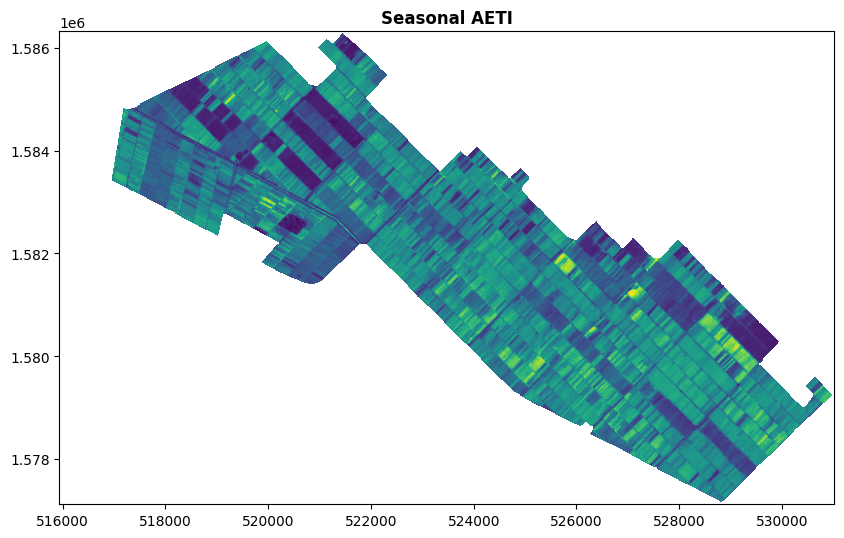

In [20]:
with rasterio.open(seasonal_AETI) as seasonal:                        # Open the raster file
    fig, ax = plt.subplots(figsize=(10, 10))                # Create a matplotlib figure and axis object with a specified size
    show(seasonal, ax=ax, title='Seasonal AETI')                 # Use rasterio's show function to display the raster data on the axes
    plt.show()                                              # Display the plot

To add more elements to the map you can adapt the script below.  



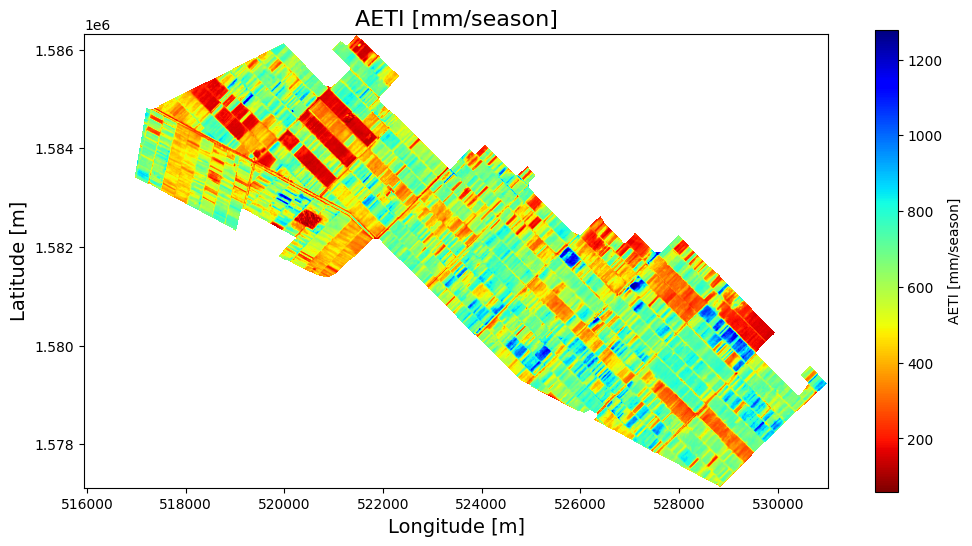

In [21]:
seasonal = rio.open(seasonal_AETI)
spatial_extent = (seasonal.bounds.left, seasonal.bounds.right, seasonal.bounds.bottom, seasonal.bounds.top)

# Read the first band
data = seasonal.read(1)

# Plotting
plt.figure(figsize=(12, 8))
plt.imshow(data, cmap='jet_r', vmin=np.nanmin(data), vmax=np.nanmax(data), extent=spatial_extent)
plt.colorbar(shrink=0.75, label='AETI [mm/season]')
plt.xlabel('Longitude [m]', fontsize=14)
plt.ylabel('Latitude [m]', fontsize=14)
plt.title('AETI [mm/season]', fontsize=16)
plt.show()



---



## **Step 3 - Calculate average seasonal AETI for each farm and calculate statistics**

Upload and read the area of interest. In this case the WH_Field.geojson file that contains information about 214 individual fields within the Wad Helal irrigation block that cropped Wheat in the 2022/2023 winter season.

**NOTE** Also upload the WaPOR AETI dekadal data which you also used in Notebook 02. Dont forget to unzip the file!

In [37]:
shapefile_path = '/content/fields.shp'
folder_path = '/content'

<Axes: >

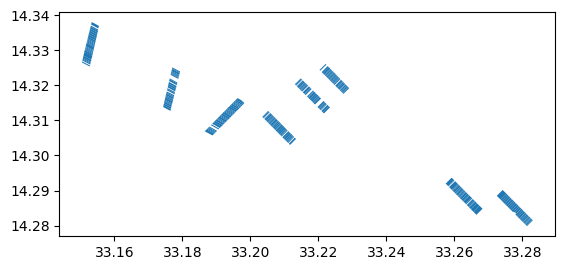

In [81]:
gdf = gpd.read_file(shapefile_path)
# Plotting the fields
gdf.plot()

We want to get the mean seasonal AET for each of these farms.

Suzan: this script gives an error "AttributeError: 'str' object has no attribute 'rio'"



In [38]:
def extract_identifier_from_filename(filename):
    parts = filename.split('_')
    date_part = parts[0]
    return date_part.rstrip('.tif')


# Convert CRS to EPSG:32636 if necessary
if gdf.crs != 'epsg:32636':
    gdf = gdf.to_crs(epsg=32636)

# Calculate area of each polygon in square meters
gdf['Area_sqm'] = gdf.area

# Initialize results DataFrame
results_gdf = gdf.copy()

# Find all TIFF files in the folder
tif_files = glob.glob(os.path.join(folder_path, "*.tif"))
print(f"Found {len(tif_files)} TIFF files to process.")

# Process each TIFF file
for tif_file in tif_files:
    # Extract identifier from filename
    identifier = extract_identifier_from_filename(os.path.basename(tif_file))

    # Calculate zonal statistics for mean
    stats = zonal_stats(gdf, tif_file, stats="mean", nodata=-9999)  # Assuming -9999 as NoData value; adjust as necessary

    # Extract mean values and assign to new column in DataFrame
    means = [stat['mean'] if stat else None for stat in stats]
    results_gdf[identifier] = means

# Remove the geometry column from the results DataFrame for easier data handling/viewing
results_df = results_gdf.drop(columns=['geometry','path'])

# Now the DataFrame 'results_df' holds the results without the geometry column and includes area calculations
print("Mean zonal statistics by date/identifier are stored in the DataFrame, including area calculations.")


Found 1 TIFF files to process.
Mean zonal statistics by date/identifier are stored in the DataFrame, including area calculations.


In [93]:
results_df

,id,yield,layer,Area_sqm,AETIseason3
0,3201,3.31,BahiEddin11,15709.611935,681.741026
1,3202,3.10,BahiEddin11,14110.138587,735.783784
2,3203,2.32,BahiEddin11,14151.018939,756.320588
3,3204,3.30,BahiEddin11,7985.774205,743.575000
4,3205,3.32,BahiEddin11,8141.727369,724.530000
...,...,...,...,...,...
209,1220,3.17,Hegeiliga_Median,8197.931434,749.377778
210,1221,3.17,Hegeiliga_Median,8092.891982,740.336842
211,1222,1.98,Hegeiliga_Median,32143.973965,735.608642
212,1223,2.64,Hegeiliga_Median,7392.372200,746.166667


from matplotlib import pyplot as plt
results_df['id'].plot(kind='hist', bins=20, title='id')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['yield'].plot(kind='hist', bins=20, title='yield')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['Area_sqm'].plot(kind='hist', bins=20, title='Area_sqm')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['AETIseason3'].plot(kind='hist', bins=20, title='AETIseason3')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
results_df.groupby('layer').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='id', y='yield', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='yield', y='Area_sqm', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df.plot(kind='scatter', x='Area_sqm', y='AETIseason3', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
results_df['id'].plot(kind='line', figsize=(8, 4), title='id')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['yield'].plot(kind='line', figsize=(8, 4), title='yield')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['Area_sqm'].plot(kind='line', figsize=(8, 4), title='Area_sqm')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
results_df['AETIseason3'].plot(kind='line', figsize=(8, 4), title='AETIseason3')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['layer'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='id', y='layer', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['layer'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='yield', y='layer', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['layer'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='Area_sqm', y='layer', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(results_df['layer'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(results_df, x='AETIseason3', y='layer', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)


To calculate the min, max and mean of the seasonal AETI and Farm area for each farm we use the following Panda functions, which we introduced in [Notebook 01 Introduction to Pandas and Geopandas](https://github.com/wateraccounting/WaPORMOOC/blob/main/3_Python_for_WaPOR/N01_Intro_Pandas_and_Geopandas.ipynb):
```python
    df.iloc[:,1:] # Selects the column of the dataframe starting from the second column
    .agg(['min', 'max', 'mean']) # aggregate function to calculate the min, max and mean of the selected dataframe columns
    .round() # function to round the values of the columns
    .astype(int) # to change the data type of the columns to integer

```

In [94]:
# applying the above functions to get minimum, maximum and mean of the AETI and the area
mm = results_df.iloc[:,4:].agg(['min', 'max', 'mean']).round().astype(int)
mm

,AETIseason3
min,409
max,835
mean,654


Saving the dataframes computed above to csv and download them to local folder:

In [92]:
# for dataframe df
file_name1 = f'AETI_and_Area_per_farm_Wad_Helal.csv'
results_df.to_csv(file_name1)

# for dataframe mm
file_name2 = f'Stat_for_Wad_Helal_farms.csv'
mm.to_csv(file_name2)

#download the two csv files
files.download(file_name1)
files.download(file_name2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Step 4 - Compute average AETI for all farms within on tertiary unit**


We can visualise the map of the farms with a differentiation between the different tertiary units (in the DataFrame, each tertiary unit has a different name in the 'layer' column).

Suzan: can you add this visualisation?

<ipython-input-93-518963a62691>:16: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(title='Tertiary Unit')


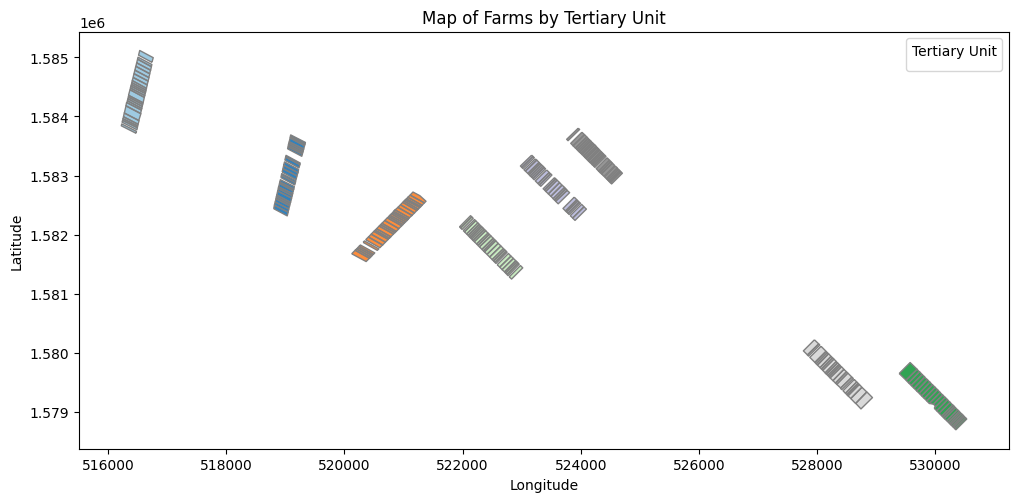

In [93]:
# Prepare the figure and axis
fig, ax = plt.subplots(figsize=(12, 12))  # Adjust the figure size as necessary
gdf.boundary.plot(ax=ax, linewidth=1, color='gray')  # Draw boundaries with gray lines

# Generate a colormap for the unique layers
layers = gdf['layer'].unique()
colors = plt.cm.tab20c(np.linspace(0, 1, len(layers)))  # Choosing a color map and generating colors
color_dict = dict(zip(layers, colors))  # Create a dictionary to map layers to colors

# Plot each layer with a different color
for layer in layers:
    subset = gdf[gdf['layer'] == layer]
    subset.plot(ax=ax, label=layer, color=color_dict[layer])

# Add a legend to the plot with a title
ax.legend(title='Tertiary Unit')

# Set titles and labels
plt.title('Map of Farms by Tertiary Unit')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()


As you can see from the above plot, we have information from 8 tertiary units with several fields within each tertiary unit.

You can get the name of the fields using the following code:

In [98]:
# get the name of the fields
np.unique(results_df['layer'])

array(['BahiEddin11', 'BahiEddin21', 'BahiEddin3', 'Eltukl10',
       'FakiMusa1', 'FakiMusa6', 'FakiMusa9', 'Hegeiliga_Median'],
      dtype=object)

We want to find all the fields within one tertiary unit. We will use the following code to find all fields within the **`'FakiMusa6'`** unit as an example:



**Excercise 1** We have information about several fields within this tertiary unit. Can you find out how many fields within this tertiary unit are listed in this DataFrame? Note down this answer, you need it in the MOOC quiz!

HINT: check out **Exercise 3** of [Notebook 01 Introduction to Pandas and Geopandas](https://github.com/wateraccounting/WaPORMOOC/blob/main/3_Python_for_WaPOR/N01_Intro_Pandas_and_Geopandas.ipynb)

In [ ]:
# Number of Polygons in FakiMusa6 field





---



<div class="alert alert-success">

## **Step 5: EXERCISE**:

>Do the zonal statistics for tertiary unit **`'FAkiMusa6`** and get the minimum, maximum and mean of the seasonal average AETI and the area of each farm.

>Note down the values (rounded to the integer values), you will need them for the MOOC quiz.


<details>
  <summary>Hints</summary>

>Select the field **`'FakiMusa6'`** from the geodataframe (at the 13th cell) and run the last three cells.

</details>
    
</div>



In [ ]:
# create a Pandas DataFrame with the seasonal AETI, area and ID of each polygon


# applying the above functions to get minimum, maximum and mean of the AETI and the area





---



## **Step 6 Visualising decadal AETI time series**
In you want to get a timeseries of decadal AETI per farm, you can run the following three cells and using the dataframe of the tertiary unit **`'FakiMusa6'`**

### **Steps:**

1. Upload the timeseries downloaded for Notebook 02.

2. Use the same tertiary unit as above (FakiMusa6) and the decadal AETI data
3. Iterate over the farms of the tertiary unit, clip the dataarray by each farm and compute the average AETI per farm
4. Save the result of each iteration in a dictionary (decadal_AETI)
5. Convert the dictionary to a dataframe
6. Assign the dataarray time to index of the dataframe
7. Plot the dataframe



To start working with the Wad Helal AETI dekadal data we follow the following steps:
*  Upload .zip to your colab files
*  Unzip file
*  Get list of files


In [1]:
#To upload file.
from google.colab import files
uploaded = files.upload()

Saving Decadal_AETI.zip to Decadal_AETI.zip


In [5]:
# unzip the uploaded zipfile
!unzip '/content/Decadal_AETI.zip' -d '/content/'

Archive:  /content/Decadal_AETI.zip
replace /content/tifs/L3-AETI-D/L3-AETI-D_20221001.tif? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [9]:
import glob  # Import the glob module
import xarray as xr
import geopandas as gpd
import rioxarray

Calculating mean dekadal values of AETI for all farms within the Faki_Musa6 tertiary unit, and create a DataFrame.

In [41]:
shapefile_path = '/content/fields.shp'     ## path to shapefile of the fields
folder_path = '/content/tifs/L3-AETI-D'    ## path to dekadal files folder

In [71]:
def extract_identifier_from_filename(filename):      ## make sure to identify which part of teh file name has date
    parts = filename.split('_')
    date_part = parts[1]
    return date_part.rstrip('.tif')

# Assuming 'gdf' is loaded from 'shapefile_path'
gdf = gpd.read_file(shapefile_path)

# Ensure the CRS is correct
if gdf.crs != 'epsg:32636':
    gdf = gdf.to_crs(epsg=32636)

# Calculate the area of each polygon in square meters
gdf['Area_sqm'] = gdf.area

# Drop rows with invalid or None geometries
gdf = gdf[gdf.geometry.notnull() & gdf.is_valid]


tif_files = glob.glob(os.path.join(folder_path, "*.tif"))
print(f"Found {len(tif_files)} TIFF files to process.")

results_gdf = gdf.copy()

# Process each TIFF file
for tif_file in tif_files:
    # Extract identifier from filename
    identifier = extract_identifier_from_filename(os.path.basename(tif_file))

    # Calculate zonal statistics for mean
    stats = zonal_stats(gdf, tif_file, stats="mean", nodata=-9999)  # Adjust as necessary

    # Extract mean values and assign to new column in DataFrame
    means = [stat['mean'] if stat else None for stat in stats]
    results_gdf[identifier] = means

# Remove the geometry column from the results DataFrame for easier data handling/viewing
results_df2 = results_gdf.drop(columns=['geometry','path'])

print("Mean zonal statistics by date/identifier are stored in the DataFrame, including area calculations.")


Found 21 TIFF files to process.
Mean zonal statistics by date/identifier are stored in the DataFrame, including area calculations.


In [73]:
results_df2

,id,yield,layer,Area_sqm,20230211,20230301,20230421,20230411,20221001,20230111,...,20221221,20230311,20221111,20230201,20221101,20230221,20221201,20230101,20230121,20230321
0,3201,3.31,BahiEddin11,15709.611935,62.235899,70.384616,6.974359,8.261539,11.410257,52.205129,...,20.223077,57.538463,6.900000,62.215386,7.707693,70.961540,7.820513,33.897436,74.969232,42.166667
1,3202,3.10,BahiEddin11,14110.138587,67.783785,82.432434,8.000000,10.313514,8.594595,52.054054,...,19.443244,70.702704,6.372973,65.297298,6.543243,79.054056,7.189189,32.891893,76.791893,54.762163
2,3203,2.32,BahiEddin11,14151.018939,68.047061,78.588237,7.823529,9.370588,8.029412,61.000001,...,29.182353,64.735295,6.326470,68.282355,6.326470,77.770589,9.264706,43.558824,83.308825,47.008825
3,3204,3.30,BahiEddin11,7985.774205,69.720001,84.300002,8.200000,9.855000,7.400000,53.100001,...,19.800001,71.650001,6.300000,67.080002,6.300000,81.000002,7.250000,33.800000,78.375001,54.340001
4,3205,3.32,BahiEddin11,8141.727369,67.880002,82.650001,8.350000,10.935000,7.400000,49.850001,...,17.930000,70.750001,6.300000,64.960001,6.210000,79.470001,7.000000,30.850001,75.075001,54.505001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,1220,3.17,Hegeiliga_Median,8197.931434,66.400001,77.666668,8.611111,12.650000,5.666667,59.388890,...,30.005556,64.944445,5.600000,65.866668,4.450000,76.400001,9.666667,42.444445,80.788891,49.377778
210,1221,3.17,Hegeiliga_Median,8092.891982,66.105264,77.842107,8.315790,12.173685,6.105263,57.894738,...,27.789474,64.947369,5.684211,65.515791,4.594737,76.500002,9.157895,40.894737,79.836843,49.210528
211,1222,1.98,Hegeiliga_Median,32143.973965,61.116051,71.592594,10.061729,13.577778,6.543210,59.111112,...,35.240741,60.185186,5.700000,61.244446,4.788889,70.822224,12.901235,45.432099,76.932100,47.232100
212,1223,2.64,Hegeiliga_Median,7392.372200,65.866668,78.444446,8.611111,11.200001,6.666667,57.555556,...,29.638889,65.611112,5.700000,64.533335,4.800000,76.700003,11.222223,41.944445,78.772223,49.683334


In [44]:
# save the dataframe and download to local folder
file_name = f'decadal_AETI_timeseries_for_field.csv'
results_df2.to_csv(file_name)

#download the two csv files
files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [98]:
df = pd.read_csv(r'decadal_AETI_timeseries_for_field.csv',index_col=1)
df = df.iloc[:, 4:] #exclude other columns, keep only time-series data
df

,20230211,20230301,20230421,20230411,20221001,20230111,20221021,20221211,20221121,20230401,...,20221221,20230311,20221111,20230201,20221101,20230221,20221201,20230101,20230121,20230321
id,,,,,,,,,,,,,,,,,,,,,
3201,62.235899,70.384616,6.974359,8.261539,11.410257,52.205129,9.561539,12.717949,7.717949,17.261539,...,20.223077,57.538463,6.900000,62.215386,7.707693,70.961540,7.820513,33.897436,74.969232,42.166667
3202,67.783785,82.432434,8.000000,10.313514,8.594595,52.054054,7.462162,11.675676,7.459459,22.986487,...,19.443244,70.702704,6.372973,65.297298,6.543243,79.054056,7.189189,32.891893,76.791893,54.762163
3203,68.047061,78.588237,7.823529,9.370588,8.029412,61.000001,6.632353,16.852941,7.823529,19.164706,...,29.182353,64.735295,6.326470,68.282355,6.326470,77.770589,9.264706,43.558824,83.308825,47.008825
3204,69.720001,84.300002,8.200000,9.855000,7.400000,53.100001,6.710000,11.600000,7.700000,21.960000,...,19.800001,71.650001,6.300000,67.080002,6.300000,81.000002,7.250000,33.800000,78.375001,54.340001
3205,67.880002,82.650001,8.350000,10.935000,7.400000,49.850001,6.380000,10.300000,7.800000,23.400000,...,17.930000,70.750001,6.300000,64.960001,6.210000,79.470001,7.000000,30.850001,75.075001,54.505001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1220,66.400001,77.666668,8.611111,12.650000,5.666667,59.388890,4.461111,18.055556,8.055556,23.350001,...,30.005556,64.944445,5.600000,65.866668,4.450000,76.400001,9.666667,42.444445,80.788891,49.377778
1221,66.105264,77.842107,8.315790,12.173685,6.105263,57.894738,4.921053,16.421053,8.210526,22.878948,...,27.789474,64.947369,5.684211,65.515791,4.594737,76.500002,9.157895,40.894737,79.836843,49.210528
1222,61.116051,71.592594,10.061729,13.577778,6.543210,59.111112,4.793827,22.592593,8.259259,23.544445,...,35.240741,60.185186,5.700000,61.244446,4.788889,70.822224,12.901235,45.432099,76.932100,47.232100


In [99]:
df = df.transpose() #transpose dataframe
df

id,3201,3202,3203,3204,3205,3206,3207,3208,3209,3210,...,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224
20230211,62.235899,67.783785,68.047061,69.720001,67.880002,53.511112,54.924139,55.157895,68.244446,65.644446,...,75.488002,71.368423,70.189475,64.647620,66.151112,66.400001,66.105264,61.116051,65.866668,64.596827
20230301,70.384616,82.432434,78.588237,84.300002,82.650001,61.733334,69.655173,79.473685,84.444446,75.277779,...,86.400003,80.921054,78.842106,73.285715,74.866668,77.666668,77.842107,71.592594,78.444446,72.396827
20230421,6.974359,8.000000,7.823529,8.200000,8.350000,8.133333,8.379311,11.473685,8.916667,8.166667,...,8.680000,8.736842,9.157895,10.285714,7.844445,8.611111,8.315790,10.061729,8.611111,10.047619
20230411,8.261539,10.313514,9.370588,9.855000,10.935000,9.320000,10.582759,17.763158,12.050000,10.200000,...,12.384000,11.984211,12.221053,12.814286,9.720000,12.650000,12.173685,13.577778,11.200001,11.700000
20221001,11.410257,8.594595,8.029412,7.400000,7.400000,11.355556,10.586207,8.210526,7.027778,7.944445,...,6.080000,7.210526,5.894737,6.285714,5.755556,5.666667,6.105263,6.543210,6.666667,6.142857
20230111,52.205129,52.054054,61.000001,53.100001,49.850001,45.222223,39.965518,33.526316,50.472223,56.166668,...,67.360001,63.315790,67.263159,56.190477,60.577778,59.388890,57.894738,59.111112,57.555556,66.079366
20221021,9.561539,7.462162,6.632353,6.710000,6.380000,8.873333,8.231035,6.831579,6.111111,6.477778,...,4.884000,6.281579,4.573684,4.714286,5.182222,4.461111,4.921053,4.793827,4.950000,5.534921
20221211,12.717949,11.675676,16.852941,11.600000,10.300000,12.533334,10.896552,9.894737,11.805556,13.833334,...,20.400000,18.342106,20.315790,15.761905,17.666667,18.055556,16.421053,22.592593,18.666667,22.650794
20221121,7.717949,7.459459,7.823529,7.700000,7.800000,7.933333,7.862069,8.000000,7.611111,7.444444,...,7.920000,7.947369,7.894737,8.000000,7.977778,8.055556,8.210526,8.259259,8.611111,8.444445
20230401,17.261539,22.986487,19.164706,21.960000,23.400000,16.120000,20.606897,36.947369,26.650000,20.450000,...,24.804000,22.286843,22.500001,21.000000,17.380000,23.350001,22.878948,23.544445,21.650001,19.785715


<Axes: >

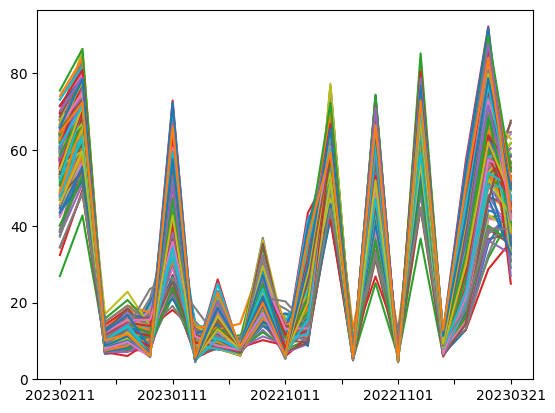

In [100]:
df.plot(legend=False) #result is not sorted by time

In [101]:
# convert id in string format to datetime
df.index= pd.to_datetime(df.index, format='%Y%m%d')
df

id,3201,3202,3203,3204,3205,3206,3207,3208,3209,3210,...,1215,1216,1217,1218,1219,1220,1221,1222,1223,1224
2023-02-11,62.235899,67.783785,68.047061,69.720001,67.880002,53.511112,54.924139,55.157895,68.244446,65.644446,...,75.488002,71.368423,70.189475,64.647620,66.151112,66.400001,66.105264,61.116051,65.866668,64.596827
2023-03-01,70.384616,82.432434,78.588237,84.300002,82.650001,61.733334,69.655173,79.473685,84.444446,75.277779,...,86.400003,80.921054,78.842106,73.285715,74.866668,77.666668,77.842107,71.592594,78.444446,72.396827
2023-04-21,6.974359,8.000000,7.823529,8.200000,8.350000,8.133333,8.379311,11.473685,8.916667,8.166667,...,8.680000,8.736842,9.157895,10.285714,7.844445,8.611111,8.315790,10.061729,8.611111,10.047619
2023-04-11,8.261539,10.313514,9.370588,9.855000,10.935000,9.320000,10.582759,17.763158,12.050000,10.200000,...,12.384000,11.984211,12.221053,12.814286,9.720000,12.650000,12.173685,13.577778,11.200001,11.700000
2022-10-01,11.410257,8.594595,8.029412,7.400000,7.400000,11.355556,10.586207,8.210526,7.027778,7.944445,...,6.080000,7.210526,5.894737,6.285714,5.755556,5.666667,6.105263,6.543210,6.666667,6.142857
2023-01-11,52.205129,52.054054,61.000001,53.100001,49.850001,45.222223,39.965518,33.526316,50.472223,56.166668,...,67.360001,63.315790,67.263159,56.190477,60.577778,59.388890,57.894738,59.111112,57.555556,66.079366
2022-10-21,9.561539,7.462162,6.632353,6.710000,6.380000,8.873333,8.231035,6.831579,6.111111,6.477778,...,4.884000,6.281579,4.573684,4.714286,5.182222,4.461111,4.921053,4.793827,4.950000,5.534921
2022-12-11,12.717949,11.675676,16.852941,11.600000,10.300000,12.533334,10.896552,9.894737,11.805556,13.833334,...,20.400000,18.342106,20.315790,15.761905,17.666667,18.055556,16.421053,22.592593,18.666667,22.650794
2022-11-21,7.717949,7.459459,7.823529,7.700000,7.800000,7.933333,7.862069,8.000000,7.611111,7.444444,...,7.920000,7.947369,7.894737,8.000000,7.977778,8.055556,8.210526,8.259259,8.611111,8.444445
2023-04-01,17.261539,22.986487,19.164706,21.960000,23.400000,16.120000,20.606897,36.947369,26.650000,20.450000,...,24.804000,22.286843,22.500001,21.000000,17.380000,23.350001,22.878948,23.544445,21.650001,19.785715


<Axes: >

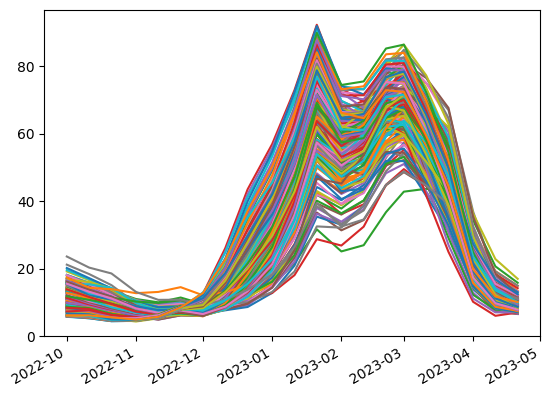

In [102]:
df.plot(legend=False) # result is sorted by time

<Axes: >

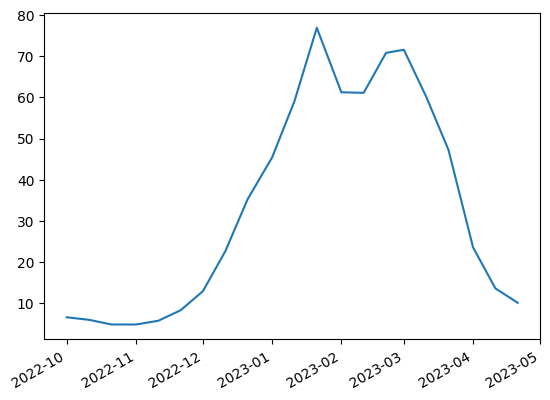

In [103]:
df[1222].plot()

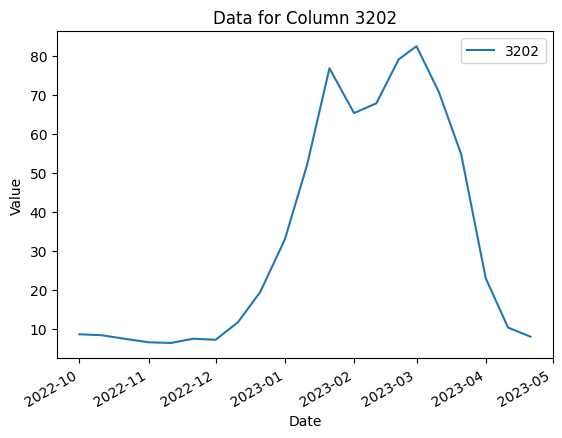

In [104]:
df[3202].plot(legend=True, title='Data for Column 3202')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

##**Plotting with Pandas**

There are multiple ways of many plots - one is to use the inbuilt function from pandas (which uses matplotlib in the backend by default), and another is to use matplotlib directly. We will briefly look into both of these.
To start, let us use the .plot() function you have seen in the previous notebook. We can plot all of the series at once:


or or select one column to plot:

Here we can see the default plot for this type of data.
A number of elements are missing, for example a title, axis labels and units... These elements can be added/changed by adding arguments to the .plot() call.

* The axis labels `ylabel`
* The plot title with `title`
* The line `style`
* The figure size with `figsize`

You can find a reference for the different options [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)

You may also want to produce scatter plots, or xy plots to compare how the ET of two plots compares. You can do this by changing the style of your plot and defining the x and y variables as shown below.


##**Plotting with MatPlotLib**

This .plot() call will only work on a dataframe, so if you have data in arrays or lists or if you want to make certain kinds of plots and have better control over your figure you may need to use matplotlib instead.
To make a similar plot to that of the scatter above, we can use the scatter function from matplotlib.pyplot (imported as plt in cell 1):

In [ ]:
# # if you want to delete a folder use the code below.
# !rm -rf /content/L3-AETI-D
# !rm -rf /content/tifs
# !rm -rf /content/L3-AETI-D.zip